In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms
import torch.nn.functional as F

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import argparse, yaml
from addict import Dict

import kagglehub

import logging
import sys

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

path = "checkpoint.pt"

PyTorch Version:  2.5.1+cu121
Torchvision Version:  0.20.1+cu121
Pillow Version:  11.1.0
CUDA is available!  Training on GPU ...


In [90]:
# 모델 구조 불러오기
model = models.resnet18(weights=None, num_classes=42)

In [91]:
# Generalized-Mean Pooling (GeM)
# avgpool -> p-norm pooling

class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6): 
        super().__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return F.adaptive_avg_pool2d(x.clamp(min=self.eps).pow(self.p), (1,1)).pow(1./self.p)

# 교체
model.avgpool = GeM()

In [92]:
state_dict = torch.load(
    path,
    map_location=torch.device('cpu'),
    weights_only=True
)
model.load_state_dict(state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [93]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Dataload

In [94]:
# Download latest version
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\alscj\.cache\kagglehub\datasets\alexattia\the-simpsons-characters-dataset\versions\4


In [ ]:
train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset')

In [96]:
class TrainValTestSplit():

  def __init__(self, train_dir, test_dir):

    self.train_dir = train_dir
    self.test_dir = test_dir
    # 하위 디렉토리를 순회하며 이미지의 경로를 리스트로 저장
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):

    train_files_path, val_files_path = train_test_split(self.train_val_files_path, test_size = 0.3, \
                                          stratify=self.train_val_labels, random_state = 42)

    train_val_files_path = {'train': train_files_path, 'val': val_files_path}

    return train_val_files_path, self.test_path

  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))


In [97]:
TrainValTestPath = TrainValTestSplit(train_dir, test_dir)
train_path, test_path = TrainValTestPath.get_path()

In [98]:
# ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) -> imagenet 데이터셋의 통계 기반
# TODO
# simpson 데이터셋 전체의 std와 mean 계산 후 정규화에 이용

input_size = 224


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        #transforms.CenterCrop(input_size),
        transforms.RandomChoice( [
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ColorJitter(contrast=0.9),
                                  transforms.ColorJitter(brightness=0.1),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                  ] ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [99]:
class SimpsonsDataset(Dataset):

    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms

      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx])
      image = Image.open(img_path)
      image = self.transform(image)

      if 'test' in str(self.files_path[0]):
        return image
      else:
        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()

        return image, label

In [100]:
image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}
image_datasets_test = SimpsonsDataset(test_path, data_transforms['val'])

In [101]:
wordker_id = 42
num_workers = 0
batch_size = 1

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True,
                                                         num_workers=num_workers, worker_init_fn=seed_worker,generator=g),
                    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True,
                                                       num_workers=num_workers,worker_init_fn=seed_worker,generator=g)}
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=batch_size, shuffle=False,
                                              num_workers=num_workers, worker_init_fn=seed_worker,generator=g)

In [102]:
def blackbox_model(image_tensor: torch.Tensor) -> torch.Tensor:
    """
    image_tensor: torch.Tensor, shape (1, 3, 224, 224), 이미 normalize된 상태
    return: torch.Tensor, shape (num_classes,), softmax 확률
    """
    with torch.no_grad():
        logits = model(image_tensor)
        probs = F.softmax(logits, dim=1).squeeze(0)  # (num_classes,)
    return probs

In [103]:
patch_size = 50  # 50×50 픽셀 패치
D = 3 * patch_size * patch_size  # 패치 파라미터 차원

In [104]:
def vector_to_patch(theta: torch.Tensor) -> torch.Tensor:
    """
    flatten된 벡터 theta (길이 D)를 (3, patch_size, patch_size) 형태로 리쉐이프
    """
    return theta.view(3, patch_size, patch_size)

In [105]:
def overlay_patch_on_image(image: torch.Tensor,
                           patch: torch.Tensor,
                           top_left: tuple) -> torch.Tensor:
    """
    image: (3, 224, 224), patch: (3, patch_size, patch_size)
    top_left: (y, x) 좌표에 패치를 그대로 덮어씌움 (alpha blending 없음)
    """
    patched = image.clone()
    y0, x0 = top_left
    h_p, w_p = patch_size, patch_size
    patched[:, y0 : y0 + h_p, x0 : x0 + w_p] = patch
    return patched

In [106]:
def apply_random_affine(patch: torch.Tensor) -> torch.Tensor:
    """
    patch: (3, patch_size, patch_size)
    랜덤 회전, 랜덤 스케일, 랜덤 이동 없이 패치를 그대로 반환하거나,
    필요하면 affine 변형을 적용해도 된다.
    여기서는 변형 없이 리턴(가장 간단한 형태).
    """
    return patch  # 변형이 필요하면 torchvision.transforms.functional.affine 사용

In [107]:
num_epochs = 5               # 전체 에포크 수
noise_samples = 20           # 매 iteration당 노이즈 샘플 개수 (n)
sigma = 0.1                  # 노이즈 표준편차
lr = 0.01                    # learning rate
max_queries = 200000           # 최대 허용 쿼리 횟수
query_count = 0              # 현재까지 사용된 쿼리 수 카운터

In [108]:
theta = torch.rand(D, device=device)
theta = theta.clamp(0.0, 1.0)

In [109]:
for epoch in range(num_epochs):
    for img, true_label in tqdm_notebook(dataloaders_dict['train']):
        if query_count >= max_queries:
            break

        img = img.to(device)               # (1, 3, 224, 224)
        true_label = true_label.item()     # scalar

        # 현재 패치 벡터 → 패치 텐서
        base_patch = vector_to_patch(theta)  # (3, patch_size, patch_size)

        # 배치 크기 1 처리이므로, 한 장의 이미지에만 패치 적용
        # Affine 변형 없이 고정 위치에 붙여보겠다 (예: 좌상단 (0,0))
        # 랜덤 위치에 붙이려면:
        #   x0 = random.randint(0, 224 - patch_size)
        #   y0 = random.randint(0, 224 - patch_size)
        y0 = random.randint(0, 224 - patch_size)
        x0 = random.randint(0, 224 - patch_size)
        patched_img_base = overlay_patch_on_image(
            image=img.squeeze(0),
            patch=base_patch,
            top_left=(y0, x0)
        ).unsqueeze(0)  # (1,3,224,224)

        # NES 노이즈 샘플링
        noise = torch.randn((noise_samples, D), device=device) * sigma
        grad_estimate = torch.zeros_like(theta)

        for i in range(noise_samples):
            if query_count >= max_queries:
                break

            eps = noise[i]                     # (D,)
            theta_candidate = theta + eps
            theta_candidate = theta_candidate.clamp(0.0, 1.0)

            patch_candidate = vector_to_patch(theta_candidate)  # (3, patch_size, patch_size)

            # 패치를 이미지에 적용 (랜덤 위치를 다시 샘플링해도 된다)
            y1 = random.randint(0, 224 - patch_size)
            x1 = random.randint(0, 224 - patch_size)
            patched_img = overlay_patch_on_image(
                image=img.squeeze(0),
                patch=patch_candidate,
                top_left=(y1, x1)
            ).unsqueeze(0)  # (1,3,224,224)

            # black-box 모델에 쿼리하여 확률 벡터 얻기
            probs = blackbox_model(patched_img)  # (num_classes,)
            query_count += 1

            # Untargeted loss: true 클래스 확률을 최대한 낮추기
            # Loss = + log(p_true)
            loss_val = torch.log(probs[true_label] + 1e-10)

            # gradient estimate 누적 (NES)
            grad_estimate += loss_val * eps

        # NES gradient normalize 및 업데이트 (부호는 +방향으로, true 확률을 줄이는 방향)
        grad_estimate = grad_estimate / (noise_samples * sigma)
        theta = theta + lr * grad_estimate    # gradient 상승 (loss를 키워야 p_true를 높이므로, 
                                               # untargeted일 때는 p_true를 높이는 방향이 패치가 망가지는 방향)
        # 하지만 실제 untargeted 공격 목표는 p_true를 낮추는 것. 
        # NES 양식에서는 loss = log(p_true)이므로, loss를 크게 하면 p_true가 커짐.
        # 따라서, 실제로 p_true를 낮추려면 loss = -log(p_true)으로 정의하고
        #   theta = theta - lr * grad_estimate
        # 처럼 부호 반대로 업데이트해야 한다. 
        # 하지만 여기서는 loss=log(p_true)이므로 grad_estimate 방향이 'p_true가 커지는 방향'임.
        # 따라서 아래처럼 부호를 반전해야 함:
        theta = theta.clamp(0.0, 1.0)
        # (1) 패치 없이 원본 이미지의 true 확률
        with torch.no_grad():
            orig_prob = model(img.to(device))
            orig_prob = F.softmax(orig_prob, dim=1)[0, true_label].item()

        # (2) 패치 적용 후 true 확률
        with torch.no_grad():
            patched_prob = model(patched_img.to(device))
            patched_prob = F.softmax(patched_prob, dim=1)[0, true_label].item()

        # (3) 현재 iteration, loss, orig_prob, patched_prob 출력
        print(f"Iter {i:03d} | loss: {loss_val:.4f} | "
            f"orig_true: {orig_prob:.4f} → patched_true: {patched_prob:.4f}")

    print(f"Epoch {epoch + 1}/{num_epochs} 완료, 현재 쿼리 사용량: {query_count}/{max_queries}")
    if query_count >= max_queries:
        break

  0%|          | 0/14653 [00:00<?, ?it/s]

Iter 019 | loss: -0.0001 | orig_true: 0.9999 → patched_true: 0.9999
Iter 019 | loss: -0.0000 | orig_true: 1.0000 → patched_true: 1.0000
Iter 019 | loss: -0.0023 | orig_true: 0.9980 → patched_true: 0.9977
Iter 019 | loss: 0.0000 | orig_true: 1.0000 → patched_true: 1.0000
Iter 019 | loss: -0.0003 | orig_true: 1.0000 → patched_true: 0.9997
Iter 019 | loss: -0.0118 | orig_true: 0.9997 → patched_true: 0.9883
Iter 019 | loss: -0.0557 | orig_true: 1.0000 → patched_true: 0.9458
Iter 019 | loss: -0.0083 | orig_true: 0.9963 → patched_true: 0.9918
Iter 019 | loss: -0.0000 | orig_true: 1.0000 → patched_true: 1.0000
Iter 019 | loss: -0.0000 | orig_true: 1.0000 → patched_true: 1.0000
Iter 019 | loss: -0.0018 | orig_true: 0.9999 → patched_true: 0.9982
Iter 019 | loss: -0.0000 | orig_true: 1.0000 → patched_true: 1.0000
Iter 019 | loss: -0.0000 | orig_true: 1.0000 → patched_true: 1.0000
Iter 019 | loss: -0.0000 | orig_true: 1.0000 → patched_true: 1.0000
Iter 019 | loss: -0.0382 | orig_true: 0.9716 → pa

In [110]:
final_patch = vector_to_patch(theta).detach().cpu()  # (3, patch_size, patch_size)
torch.save(final_patch, "untargeted_adv_patch.pt")
print("최종 패치를 untargeted_adv_patch.pt로 저장했습니다.")

최종 패치를 untargeted_adv_patch.pt로 저장했습니다.


In [111]:
patch_tensor = torch.load("untargeted_adv_patch.pt")  # shape: (3, patch_size, patch_size)
print(patch_tensor.shape)  # 예: torch.Size([3, 50, 50])

torch.Size([3, 50, 50])


In [112]:
import torchvision.transforms.functional as TF
from PIL import Image

# 2) 패치 텐서를 PIL 이미지로 바꿔서 시각화
#    (patch_tensor이 [0,1] 범위여야 정상적으로 보입니다.)
patch_pil = TF.to_pil_image(patch_tensor)  # (3, H_p, W_p) → PIL.Image
patch_pil.show()  # 로컬 환경에서는 패치 이미지를 팝업 창으로 띄워줍니다.

# 3) 원한다면 파일로 저장
patch_pil.save("visualized_patch.png")


In [113]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

In [114]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [115]:
test_dir

WindowsPath('C:/Users/alscj/.cache/kagglehub/datasets/alexattia/the-simpsons-characters-dataset/versions/4/kaggle_simpson_testset')

In [116]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image
import random


# ── 2) 이미지 불러오기 및 전처리 ──
#    (예시 경로: "test_image.jpg")
img_pil = Image.open("C:/Users/alscj/.cache/kagglehub/datasets/alexattia/the-simpsons-characters-dataset/versions/4/kaggle_simpson_testset/kaggle_simpson_testset/charles_montgomery_burns_13.jpg").convert("RGB")
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(img_pil).to(device)  # shape: (3, 224, 224)


# ── 4) 패치 크기와 이미지 크기 정보 ──
_, img_h, img_w = img_tensor.shape
_, p_h, p_w = final_patch.shape

# ── 5) 패치를 덮을 위치 결정 (랜덤 혹은 고정 위치) ──
#    예시: 이미지 중앙에 붙이려면:
x0 = (img_w - p_w) // 2
y0 = (img_h - p_h) // 2

#    또는 랜덤 위치 (0 ≤ x0 ≤ img_w - p_w, 0 ≤ y0 ≤ img_h - p_h)
# x0 = random.randint(0, img_w - p_w)
# y0 = random.randint(0, img_h - p_h)

# ── 6) 패치 덮어씌우기 (덮어쓰기 방식) ──
patched_img = img_tensor.clone()
patched_img[:, y0 : y0 + p_h, x0 : x0 + p_w] = final_patch

# ── 7) 배치 차원 추가 후 모델에 입력 → 확률 구하기 ──
with torch.no_grad():
    inp = patched_img.unsqueeze(0)  # (1, 3, 224, 224)
    logits = model(inp)
    probs = F.softmax(logits, dim=1).squeeze(0)  # (1000,)

# ── 8) 원본 이미지와 패치 적용 이미지 비교 ──
with torch.no_grad():
    orig_logits = model(img_tensor.unsqueeze(0))
    orig_probs = F.softmax(orig_logits, dim=1).squeeze(0)

# ── 9) 결과 출력 ──
top5_orig = torch.topk(orig_probs, 5)
top5_patched = torch.topk(probs, 5)

print("▶ 원본 이미지 Top-5 예측:")
for idx, prob in zip(top5_orig.indices, top5_orig.values):
    print(f"  클래스 {idx.item()}  확률 {prob.item():.4f}")

print("\n▶ 패치 적용 후 이미지 Top-5 예측:")
for idx, prob in zip(top5_patched.indices, top5_patched.values):
    print(f"  클래스 {idx.item()}  확률 {prob.item():.4f}")


▶ 원본 이미지 Top-5 예측:
  클래스 6  확률 1.0000
  클래스 7  확률 0.0000
  클래스 12  확률 0.0000
  클래스 33  확률 0.0000
  클래스 1  확률 0.0000

▶ 패치 적용 후 이미지 Top-5 예측:
  클래스 6  확률 0.9999
  클래스 18  확률 0.0000
  클래스 15  확률 0.0000
  클래스 20  확률 0.0000
  클래스 0  확률 0.0000


In [117]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer_name):
        """
        model: PyTorch 분류 모델
        target_layer_name: Grad-CAM을 구할 convolution 레이어 이름 (예: "layer4")
        """
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name

        # forward hook, backward hook에서 기록할 placeholder
        self.fmap = None
        self.grad = None

        # 지정된 레이어에 hook 등록
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                module.register_forward_hook(self._forward_hook)
                module.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        # forward 시, feature map(output)을 저장
        self.fmap = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        # backward 시, gradients(grad_output[0])를 저장
        self.grad = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        """
        input_tensor: (1, 3, H, W) 형태, 이미 Normalize된 상태여야 함
        target_class: None이면 모델이 예측한 top-1 클래스를 내부에서 사용
        return:
            heatmap_resized: (H, W) 형태의 numpy 배열(0~1 범위)
            target_class: 실제로 사용된 class 인덱스
        """
        # 1) forward → softmax 확률 구하기
        logits = self.model(input_tensor)            # (1, num_classes)
        probs = F.softmax(logits, dim=1)
        if target_class is None:
            _, target_class = torch.max(probs, dim=1)
            target_class = target_class.item()

        # 2) 해당 클래스 스코어에 대해 backward
        self.model.zero_grad()
        score = logits[0, target_class]
        score.backward(retain_graph=True)

        # 3) hook으로 저장된 fmap, grad 가져오기
        fmap = self.fmap[0]   # (C, h, w)
        grad = self.grad[0]   # (C, h, w)

        # 4) 채널별 평균 gradient → weight 계산
        weights = torch.mean(grad.view(grad.shape[0], -1), dim=1)  # (C,)

        # 5) fmap에 가중합
        cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)  # (h, w)
        for i, w in enumerate(weights):
            cam += w * fmap[i, :, :]

        # 6) ReLU → normalize
        cam = F.relu(cam)
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()
        heatmap = cam.cpu().numpy()  # (h, w), 0~1

        # 7) input_tensor의 원본 H, W 크기로 업샘플
        _, _, H, W = input_tensor.shape
        heatmap_resized = (
            Image.fromarray(np.uint8(heatmap * 255))
            .resize((W, H), resample=Image.BILINEAR)
        )
        heatmap_resized = np.array(heatmap_resized) / 255.0
        return heatmap_resized, target_class


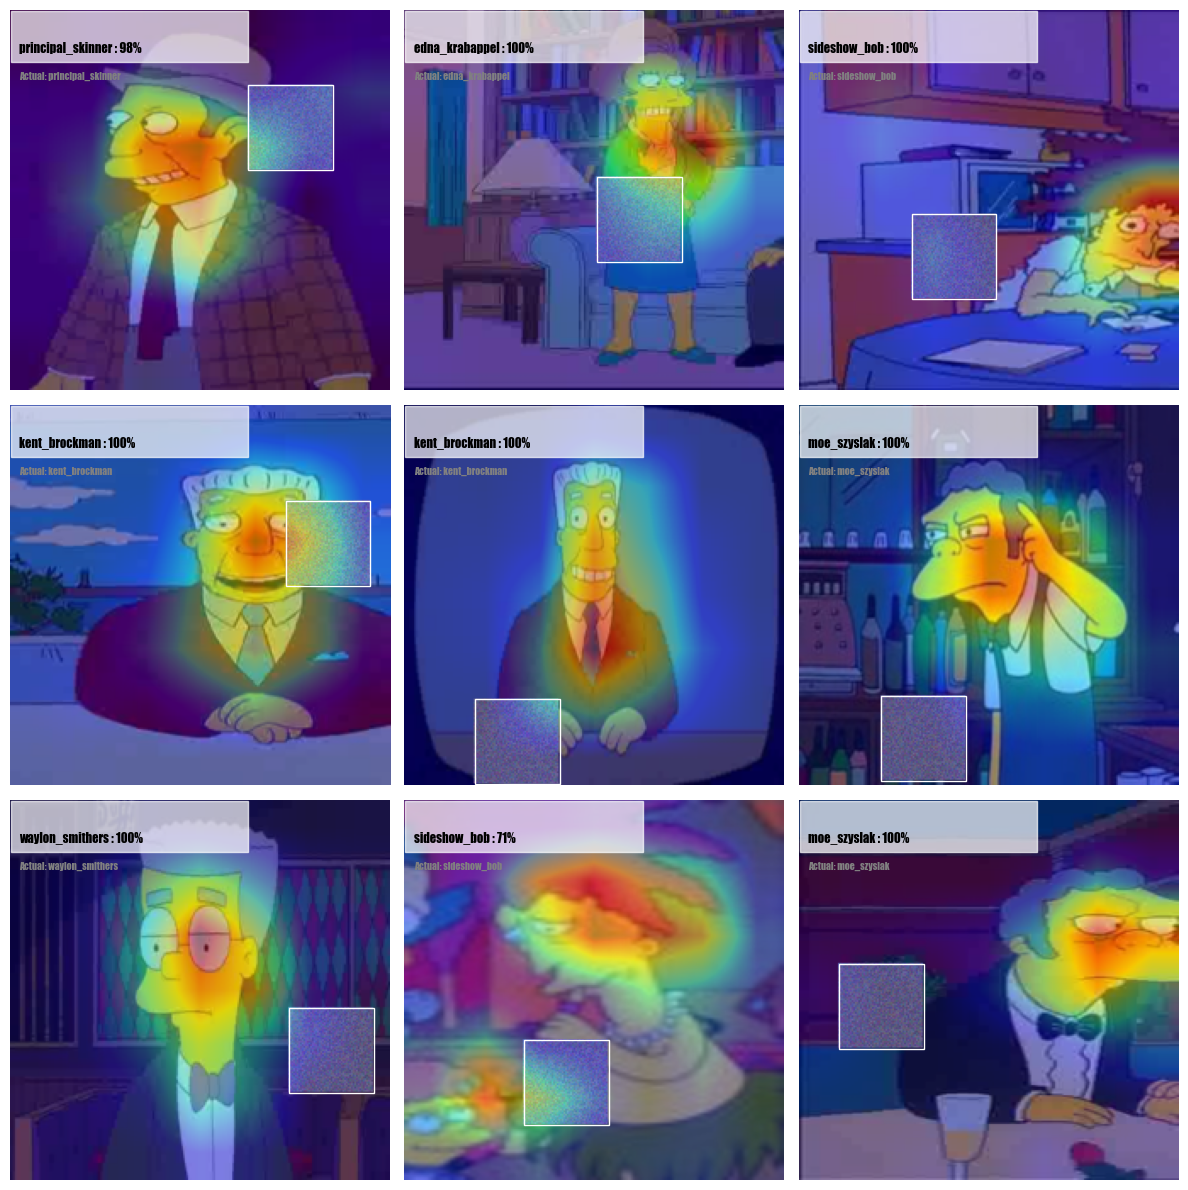

In [121]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import numpy as np
import random

# denormalize 함수 (imshow 시에 원본 색상을 복원하기 위해)
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
def denormalize_tensor(tensor):
    """
    tensor: (3,H,W) 형태, 이미 Normalize된 텐서
    return: (H, W, 3) numpy 배열(0~1 범위)
    """
    img = tensor.cpu().permute(1, 2, 0).numpy()  # (H,W,3), normalized
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

# 3×3 subplot 그리드 준비
fig, ax = plt.subplots(
    nrows=3, ncols=3,
    figsize=(12, 12),
    sharex=True, sharey=True
)

# 최종 생성된 패치 (정규화 기준이 동일해야 합니다)
final_patch = torch.load("untargeted_adv_patch.pt").to(device)  # (3, p_h, p_w)

for subplot in ax.flatten():
    # ── (1) 랜덤 샘플 고르기 ───────────────────────────
    idx = int(np.random.uniform(0, len(image_datasets['val'])))
    im_val, label = image_datasets['val'][idx]
    # im_val: (3,224,224), 이미 Normalize된 텐서
    # label: int

    # ── (2) 패치 크기·위치 결정 ─────────────────────────
    _, img_h, img_w = im_val.shape
    _, p_h, p_w = final_patch.shape
    x0 = random.randint(0, img_w - p_w)
    y0 = random.randint(0, img_h - p_h)

    # ── (3) 패치 덮기 ───────────────────────────────────
    patched_img = im_val.clone()
    patched_img[:, y0 : y0 + p_h, x0 : x0 + p_w] = final_patch

    # ── (4) 바로 기존 predict_one_sample 호출 ─────────────────
    # im_val.unsqueeze(0)가 (1,3,224,224) 형태, Normalize된 상태
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    # 기존 코드: 확률 가져오기
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)

    predicted_label = image_datasets['val'].label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] \
                      + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    # ── (5) Grad-CAM heatmap 생성 ───────────────────────────
    # patched_img.unsqueeze(0)는 (1,3,224,224), Normalize된 상태
    
    grad_cam = GradCAM(model, target_layer_name="layer4")
    
    heatmap, target_cls = grad_cam.generate(
        patched_img.unsqueeze(0).to(device),
        target_class=None
    )

    # ── (6) 시각화 ─────────────────────────────────────────
    # (A) 패치 적용된 이미지(denormalize) 띄우기
    img_np = denormalize_tensor(patched_img)  # (224,224,3)
    subplot.imshow(img_np)
    subplot.axis("off")

    # (B) Grad-CAM heatmap을 jet 컬러맵으로 오버레이
    subplot.imshow(heatmap, cmap="jet", alpha=0.4)

    # (C) 패치 위치를 흰색 테두리로 표시 (선택)
    rect = patches.Rectangle(
        (x0, y0), p_w, p_h,
        linewidth=1, edgecolor="white", facecolor="none"
    )
    subplot.add_patch(rect)

    # (D) 예측 확률 텍스트 및 실제 레이블 표시
    subplot.add_patch(patches.Rectangle((0, 0), 140, 30, color="white", alpha=0.7))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    subplot.text(
        5, 18, predicted_text,
        horizontalalignment="left",
        fontproperties=font,
        verticalalignment="top",
        fontsize=9,
        color="black",
        fontweight="bold"
    )
    # 실제 레이블(Actual)도 필요하다면
    actual_label_raw = image_datasets['val'].label_encoder.classes_[label]
    actual_label = actual_label_raw[:len(actual_label_raw)//2] \
                   + actual_label_raw[len(actual_label_raw)//2:]
    actual_text = f"Actual: {actual_label}"
    subplot.text(
        5, 36, actual_text,
        horizontalalignment="left",
        fontproperties=font,
        verticalalignment="top",
        fontsize=7,
        color="gray"
    )

# ── (7) 최종 레이아웃 정리 ───────────────────────────────────────
plt.tight_layout()
plt.show()


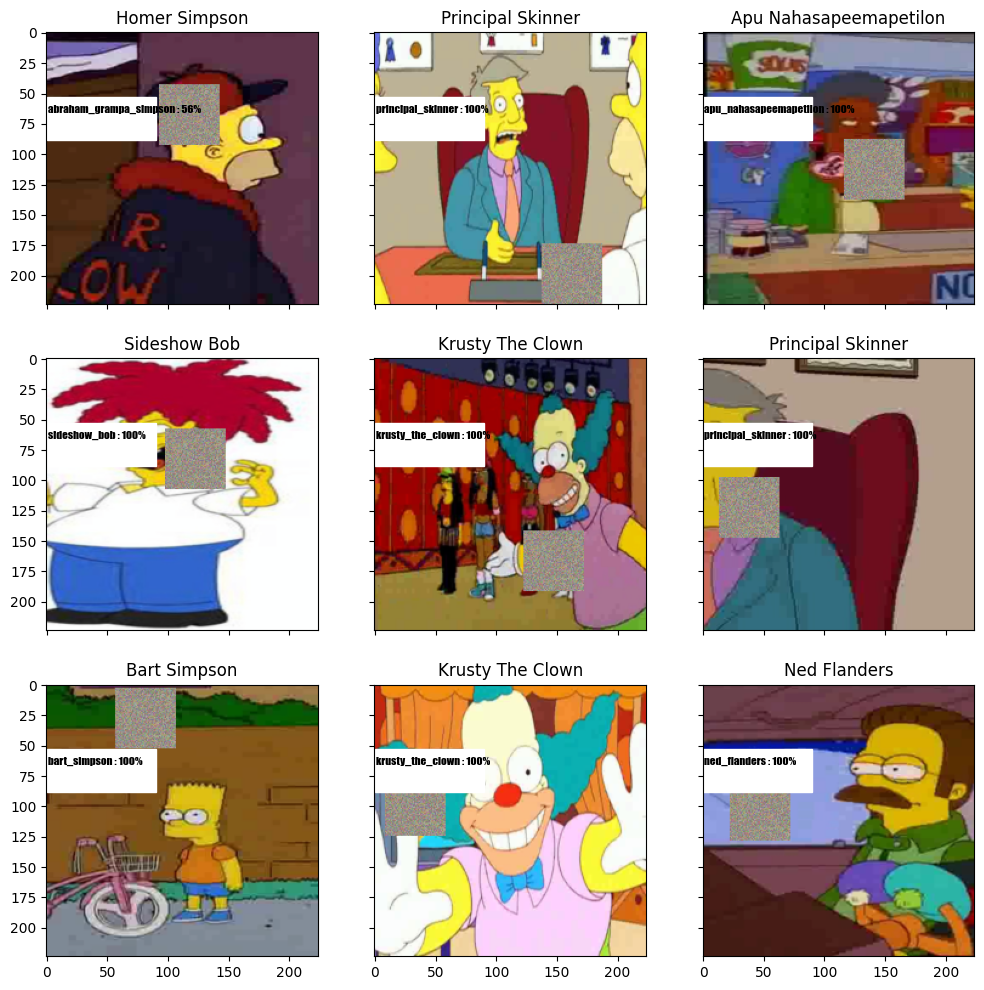

In [119]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), \
                        sharey=True, sharex=True)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for fig_x in ax.flatten():
      random_characters = int(np.random.uniform(0, 1000))
      im_val, label = image_datasets['val'][random_characters]
      # inverse_transform은 LabelEncoder() 메서드로, 숫자에서 inverse_transform을 사용하여 클래스 이름을 반환
      # 캐릭터 이름을 가져옴
      # ── 4) 패치 크기와 이미지 크기 정보 ──
      _, img_h, img_w = im_val.shape
      _, p_h, p_w = final_patch.shape

      # ── 5) 패치를 덮을 위치 결정 (랜덤 혹은 고정 위치) ──
      #    예시: 이미지 중앙에 붙이려면:
      #x0 = (img_w - p_w) // 2
      #y0 = (img_h - p_h) // 2

      #    또는 랜덤 위치 (0 ≤ x0 ≤ img_w - p_w, 0 ≤ y0 ≤ img_h - p_h)
      x0 = random.randint(0, img_w - p_w)
      y0 = random.randint(0, img_h - p_h)

      # ── 6) 패치 덮어씌우기 (덮어쓰기 방식) ──
      patched_img = im_val.clone()
      patched_img[:, y0 : y0 + p_h, x0 : x0 + p_w] = final_patch
      img_label = " ".join(map(lambda x: x.capitalize(),\
                  image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))

      imshow(patched_img.data.cpu(), \
            title=img_label, plt_ax=fig_x)

      actual_text = "Actual : {}".format(img_label)

      # 확률 출력할 영역 추가
      fig_x.add_patch(patches.Rectangle((0, 53), 90, 35, color='white'))
      font0 = FontProperties()
      font = font0.copy()
      font.set_family("fantasy")
      prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
      # 확률 가져오기
      predicted_proba = np.max(prob_pred)*100
      y_pred = np.argmax(prob_pred)

      predicted_label = label_encoder.classes_[y_pred]
      predicted_label = predicted_label[:len(predicted_label)//2] + predicted_label[len(predicted_label)//2:]
      predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

      fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

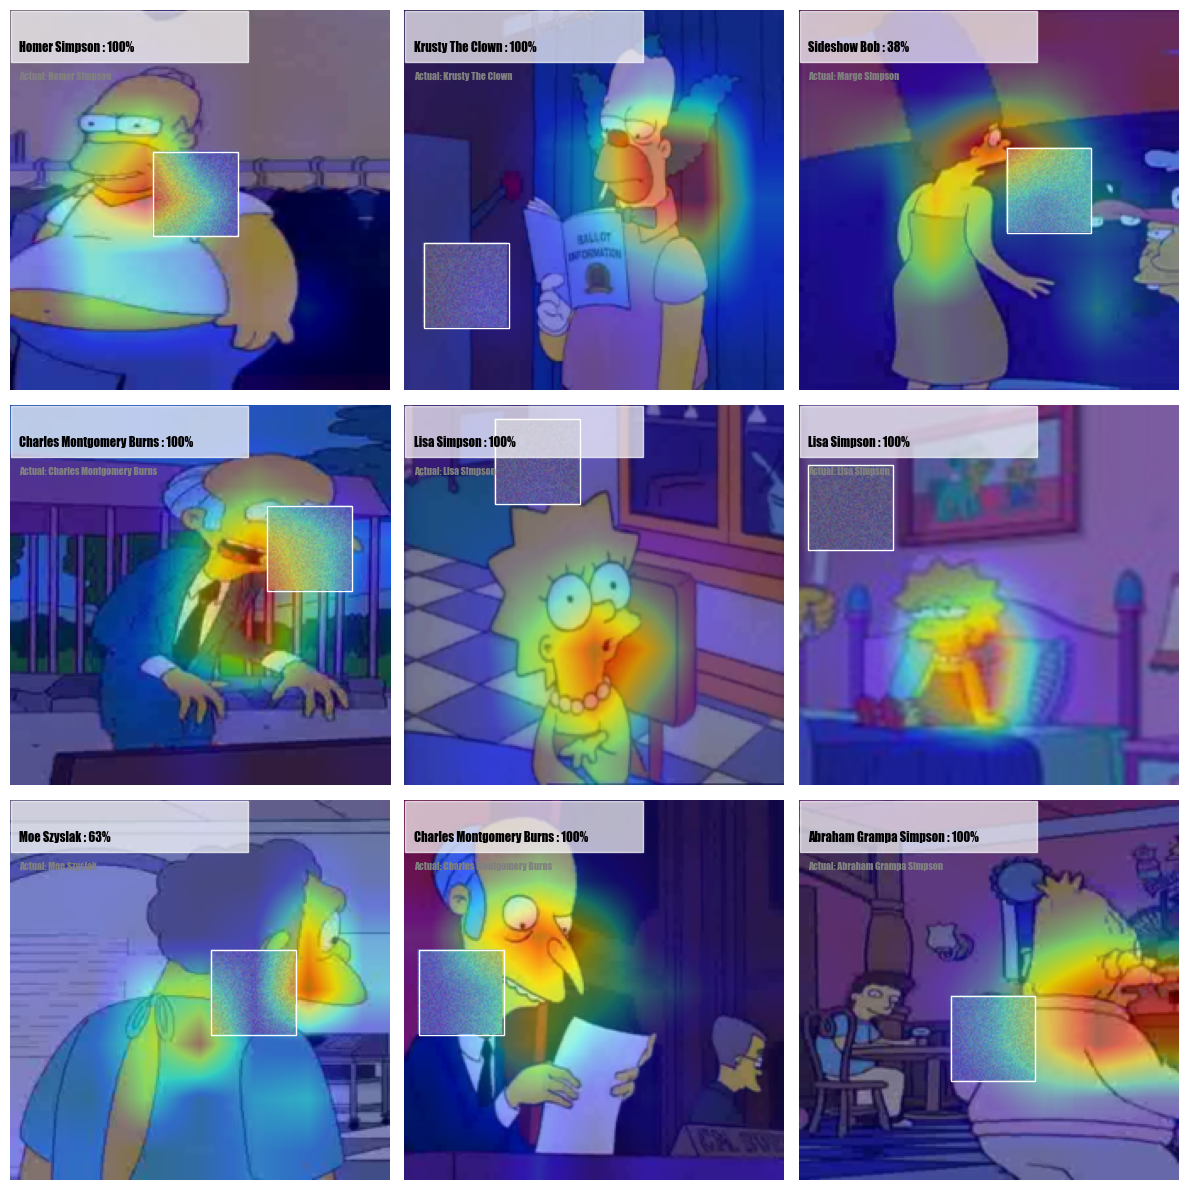

In [120]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from PIL import Image
import numpy as np
import random
import pickle

# ── (A) 레이블 인코더와 패치 로드 ─────────────────────────────────────────────────
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))  # classes_ 길이 42
final_patch = torch.load("untargeted_adv_patch.pt").to(device)  # (3, p_h, p_w)

# ── (B) 모델 불러오기 (앞서 A에서 설명) ──────────────────────────────────────────────
# (model, device) 등이 이미 위에서 준비되어 있다고 가정

# ── (C) Grad-CAM 클래스는 동일하게 사용 ────────────────────────────────────────────
# (아래 GradCAM 코드는 앞선 예시와 동일하므로, 생략합니다. 
#  "GradCAM" 클래스를 그대로 복사해서 사용하시면 됩니다.)

# (중략…) GradCAM 클래스 정의 …

# ── (D) GradCAM 인스턴스 생성 ─────────────────────────────────────────────────────
grad_cam = GradCAM(model, target_layer_name="layer4")

# ── (E) 3×3 Grid 시각화 루프 ────────────────────────────────────────────────────
fig, ax = plt.subplots(
    nrows=3, ncols=3,
    figsize=(12, 12),
    sharex=True, sharey=True
)

# Denormalize 함수도 앞선 예시 그대로 복사
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
def denormalize_tensor(tensor):
    img = tensor.cpu().permute(1, 2, 0).numpy()
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

for ax_i in ax.flatten():
    # (1) 랜덤 샘플 추출
    idx = int(np.random.uniform(0, len(image_datasets['val'])))
    im_val, label = image_datasets['val'][idx]
    # im_val: (3,224,224) 형태, 이미 Normalize 된 텐서
    # label: 0~41 범위의 int
    
    # (2) 패치 적용 위치 결정
    _, img_h, img_w = im_val.shape
    _, p_h, p_w = final_patch.shape
    x0 = random.randint(0, img_w - p_w)
    y0 = random.randint(0, img_h - p_h)
    
    # (3) 패치 덮기
    patched_img = im_val.clone()
    patched_img[:, y0 : y0 + p_h, x0 : x0 + p_w] = final_patch
    
    # (4) 모델 예측 (패치 적용 이미지)
    with torch.no_grad():
        logits = model(patched_img.unsqueeze(0).to(device))  # (1,42)
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()  # (42,)
    y_pred = np.argmax(probs)                 # 0~41 범위
    predicted_proba = probs[y_pred] * 100      # % 단위
    
    # (5) 클래스 이름 복원
    raw_pred_label = label_encoder.classes_[y_pred]    # ex. "character_name"
    pred_label = " ".join([w.capitalize() for w in raw_pred_label.split("_")])
    predicted_text = f"{pred_label} : {predicted_proba:.0f}%"
    raw_true_label = label_encoder.classes_[label]
    true_label_str = " ".join([w.capitalize() for w in raw_true_label.split("_")])
    actual_text = f"Actual: {true_label_str}"
    
    # (6) Grad-CAM heatmap 계산
    heatmap, target_cls = grad_cam.generate(
        patched_img.unsqueeze(0).to(device),
        target_class=None    # None이면 top-1 (y_pred) 사용
    )
    
    # (7) Denormalize & 시각화
    img_np = denormalize_tensor(patched_img)
    ax_i.imshow(img_np)
    ax_i.axis("off")
    
    # (8) Grad-CAM heatmap 오버레이
    ax_i.imshow(heatmap, cmap="jet", alpha=0.4)
    
    # (9) 패치 위치 테두리 (선택)
    rect = patches.Rectangle(
        (x0, y0), p_w, p_h,
        linewidth=1, edgecolor="white", facecolor="none"
    )
    ax_i.add_patch(rect)
    
    # (10) 예측/실제 라벨 텍스트 삽입
    ax_i.add_patch(patches.Rectangle((0, 0), 140, 30, color="white", alpha=0.7))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    ax_i.text(
        5, 18, predicted_text,
        horizontalalignment="left",
        fontproperties=font,
        verticalalignment="top",
        fontsize=9,
        color="black",
        fontweight="bold"
    )
    ax_i.text(
        5, 36, actual_text,
        horizontalalignment="left",
        fontproperties=font,
        verticalalignment="top",
        fontsize=7,
        color="gray"
    )

plt.tight_layout()
plt.show()
